In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [3]:
stack_fixed = 'RV13_64hrs'
stack_moving = 'atlasV5'

In [5]:
# warp_setting = 20
warp_setting = 16
# Adding surr is essential.

In [6]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
18,8,affine,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN


In [85]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

# surround_weight = warp_properties['surround_weight']
surround_weight = np.nan
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
print include_surround

upstream_warp_id                                  None
transform_type                                  affine
terminate_thresh                                 1e-05
grad_computation_sample_number                  100000
grid_search_sample_number                         1000
std_tx_um                                         2000
std_ty_um                                         2000
std_tz_um                                         2000
std_theta_xy_degree                                 30
surround_weight                                inverse
regularization_weight                              NaN
comment                           global reg with surr
max_iter_num                                       NaN
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598
False


In [86]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [87]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


(356, 427, 375)


Volume shape: (356, 427, 375)


In [88]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp
Score volume for 3N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp
Score volume for RMC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp
Score volume for SNR_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp"
(228, 543, 478)


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp'
Volume shape: (228, 543, 478)


In [89]:
structure_subset = all_known_structures_sided

In [90]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [91]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [92]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [93]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [94]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [95]:
label_weights_m

{8: 1.0,
 9: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 17: 1.0,
 24: 1.0,
 25: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 43: 1.0}

In [96]:
from registration_utilities import *

In [121]:
label_mapping_m2f = {12:3, 13:4}

In [122]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [123]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['7N_L']])

centroid_m: [ 205.97802909  302.25684995  108.02230353], centroid_f: [ 183.55561562  163.46717703   95.48517818]


In [124]:
aligner.set_label_weights(label_weights=label_weights_m)

In [125]:
# display_volume_sections(volume_fixed[structure_to_label_fixed['7N_L']], start_level=0)

In [126]:
# display_volume_sections(volume_moving[structure_to_label_moving['7N_L']], start_level=0)

In [127]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=3, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [128]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [129]:
gradients = {ind_f: np.zeros((3,)+volume_fixed.values()[0].shape, dtype=np.float16) 
             for ind_f in set(label_mapping_m2f.values())}

for ind_f in set(label_mapping_m2f.values()):

    t = time.time()

    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gx'}, is_dir=False)
    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gy'}, is_dir=False)
    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gz'}, is_dir=False)

    gradients[ind_f][0] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gx'})
    gradients[ind_f][1] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gy'})
    gradients[ind_f][2] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gz'})

    sys.stderr.write('load gradient %s: %f seconds\n' % (ind_f, time.time() - t)) # ~6s

load gradient 3: 1.148358 seconds
load gradient 4: 1.147100 seconds


In [130]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s
aligner.load_gradient(gradients=gradients)

indices_f: set([3, 4])


In [137]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
#                                      max_iter_num=MAX_ITER_NUM,
                                     max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
#                                      grad_computation_sample_number=grad_computation_sample_number,
                                     grad_computation_sample_number=100000,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.00 0.00 0.00, out T: 10.00 -10.00 10.00
step: 0.19 seconds
current score: -0.035630
new_T: [10. -10. 10.]
det: 0.88

iteration 1
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 10.00 -10.00 10.00, out T: 0.05 -0.10 0.71
step: 0.21 seconds
current score: -0.042208
new_T: [ 0.04880664 -0.09780812  0.70971657]
det: 0.80

iteration 2
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.05 -0.10 0.71, out T: 0.83 -1.46 3.14
step: 0.20 seconds
current score: -0.035455
new_T: [ 0.83184134 -1.46363257  3.1427747 ]
det: 0.86

iteration 3
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.83 -1.46 3.14, out T: 1.33 -1.63 1.20
step: 0.19 seconds
current score: -0.035638
new_T: [ 1.33316923 -1.63412059  1.20342164]
det: 0.88

iteration 4
Error computing score/gradient for 13: Image 

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.19 -0.62 5.49, out T: -0.06 -0.16 4.45
step: 0.18 seconds
current score: -0.035717
new_T: [-0.06277496 -0.16240753  4.44622034]
det: 0.78

iteration 35
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.06 -0.16 4.45, out T: 0.33 0.08 5.09
step: 0.18 seconds
current score: -0.035810
new_T: [ 0.32914362  0.0755933   5.08770264]
det: 0.79

iteration 36
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.33 0.08 5.09, out T: 0.37 -0.04 5.69
step: 0.18 seconds
current score: -0.035914
new_T: [ 0.37120148 -0.0444953   5.68909059]
det: 0.82

iteration 37
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.37 -0.04 5.69, out T: 0.35 -0.02 3.56
step: 0.18 seconds
current score: -0.036002
new_T: [ 0.347686   -0.02393424  3.55833454]
det: 0.84

iteration 38
Error computing score/gradient for 1

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.77 0.40 6.05, out T: -0.63 0.15 6.83
step: 0.17 seconds
current score: -0.039312
new_T: [-0.62510805  0.14663296  6.82709621]
det: 1.00

iteration 69
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.63 0.15 6.83, out T: -1.03 0.61 6.29
step: 0.17 seconds
current score: -0.039719
new_T: [-1.03263538  0.60938881  6.2890576 ]
det: 0.97

iteration 70
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -1.03 0.61 6.29, out T: -1.25 0.64 7.10
step: 0.16 seconds
current score: -0.039649
new_T: [-1.24926964  0.63599123  7.10338246]
det: 1.01

iteration 71
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -1.25 0.64 7.10, out T: -1.28 1.02 5.82
step: 0.16 seconds
current score: -0.039886
new_T: [-1.27521943  1.01691795  5.8205337 ]
det: 1.00

iteration 72
Error computing score/gradient for 1

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.89 0.98 6.90, out T: -0.56 1.02 6.11
step: 0.16 seconds
current score: -0.040886
new_T: [-0.56363657  1.0174993   6.11052626]
det: 1.03

iteration 103
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.56 1.02 6.11, out T: -0.48 0.69 6.61
step: 0.16 seconds
current score: -0.040662
new_T: [-0.48006665  0.69159893  6.61411956]
det: 1.06

iteration 104
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.48 0.69 6.61, out T: -0.17 1.10 5.36
step: 0.16 seconds
current score: -0.040749
new_T: [-0.17391551  1.09870141  5.3574845 ]
det: 1.05

iteration 105
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.17 1.10 5.36, out T: -0.68 0.87 6.87
step: 0.16 seconds
current score: -0.040767
new_T: [-0.67564732  0.86981763  6.87276907]
det: 1.02

iteration 106
Error computing score/gradient f

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.90 0.64 5.25, out T: -0.41 0.69 4.79
step: 0.16 seconds
current score: -0.041142
new_T: [-0.40563051  0.69166773  4.78613344]
det: 1.09

iteration 137
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.41 0.69 4.79, out T: -0.04 0.88 4.79
step: 0.16 seconds
current score: -0.041041
new_T: [-0.03562112  0.87645842  4.78519847]
det: 1.08

iteration 138
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.04 0.88 4.79, out T: -0.60 1.05 5.06
step: 0.16 seconds
current score: -0.041170
new_T: [-0.59908256  1.04660122  5.06242333]
det: 1.10

iteration 139
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.60 1.05 5.06, out T: -0.82 0.70 5.37
step: 0.16 seconds
current score: -0.041096
new_T: [-0.8163604   0.69754226  5.37360384]
det: 1.12

iteration 140
Error computing score/gradient f

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.54 0.43 5.84, out T: -0.65 0.82 5.07
step: 0.16 seconds
current score: -0.041524
new_T: [-0.65187568  0.81661561  5.06710483]
det: 1.17

iteration 171
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.65 0.82 5.07, out T: -1.10 1.02 5.80
step: 0.16 seconds
current score: -0.041556
new_T: [-1.09606944  1.01535409  5.79831677]
det: 1.17

iteration 172
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -1.10 1.02 5.80, out T: -0.67 1.17 5.81
step: 0.16 seconds
current score: -0.041671
new_T: [-0.66773548  1.168439    5.80694681]
det: 1.15

iteration 173
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.67 1.17 5.81, out T: -0.67 0.97 5.51
step: 0.16 seconds
current score: -0.041737
new_T: [-0.66880349  0.97243782  5.51151914]
det: 1.17

iteration 174
Error computing score/gradient f

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.88 1.04 5.91, out T: -0.68 1.03 5.44
step: 0.20 seconds
current score: -0.042309
new_T: [-0.68115876  1.03357116  5.4418381 ]
det: 1.28

iteration 205
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.68 1.03 5.44, out T: -0.60 0.95 6.02
step: 0.19 seconds
current score: -0.042189
new_T: [-0.60354643  0.9540863   6.02095532]
det: 1.29

iteration 206
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.60 0.95 6.02, out T: -0.84 1.02 5.66
step: 0.19 seconds
current score: -0.042410
new_T: [-0.8418847   1.02016836  5.65836652]
det: 1.29

iteration 207
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.84 1.02 5.66, out T: -1.00 0.51 6.13
step: 0.19 seconds
current score: -0.042492
new_T: [-0.99887722  0.51456504  6.13488752]
det: 1.32

iteration 208
Error computing score/gradient f

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.09 0.76 5.38, out T: -0.00 0.32 4.77
step: 0.19 seconds
current score: -0.042461
new_T: [ -3.67308605e-03   3.24294532e-01   4.76934967e+00]
det: 1.33

iteration 239
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.00 0.32 4.77, out T: -0.11 0.31 4.95
step: 0.18 seconds
current score: -0.042737
new_T: [-0.11379011  0.30626194  4.95328412]
det: 1.32

iteration 240
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: -0.11 0.31 4.95, out T: 0.27 0.60 5.15
step: 0.19 seconds
current score: -0.042470
new_T: [ 0.26915237  0.59977338  5.15237067]
det: 1.33

iteration 241
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.27 0.60 5.15, out T: 0.17 0.75 4.33
step: 0.18 seconds
current score: -0.042486
new_T: [ 0.16799867  0.75276663  4.33207234]
det: 1.31

iteration 242
Error computing scor

Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.09 0.67 4.63, out T: 0.33 0.54 4.64
step: 0.19 seconds
current score: -0.042698
new_T: [ 0.3261522   0.53630636  4.64448347]
det: 1.42

iteration 273
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.33 0.54 4.64, out T: 0.77 0.17 4.42
step: 0.19 seconds
current score: -0.042709
new_T: [ 0.76709719  0.16805446  4.42244164]
det: 1.43

iteration 274
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.77 0.17 4.42, out T: 0.30 0.30 5.51
step: 0.19 seconds
current score: -0.042515
new_T: [ 0.30105113  0.30267765  5.50590268]
det: 1.42

iteration 275
Error computing score/gradient for 13: Image gradient at all valid voxel is zero.
in T: 0.30 0.30 5.51, out T: -0.26 0.24 4.67
step: 0.19 seconds
current score: -0.042415
new_T: [-0.26011782  0.24024242  4.66671762]
det: 1.42

iteration 276
Error computing score/gradient for 13: 

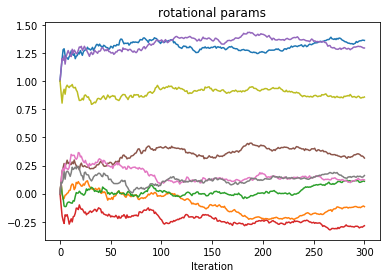

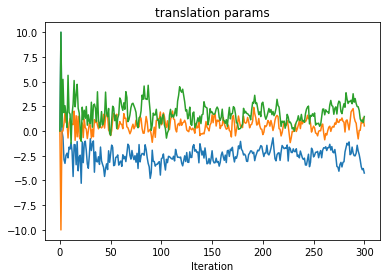

In [135]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.155058222364 -0.155924549798
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]


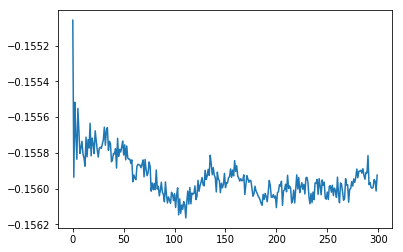

In [136]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [ ]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [ ]:
structure = '3N_L'

In [ ]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [ ]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

In [ ]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0)